In [1]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

## Load and visualize data

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


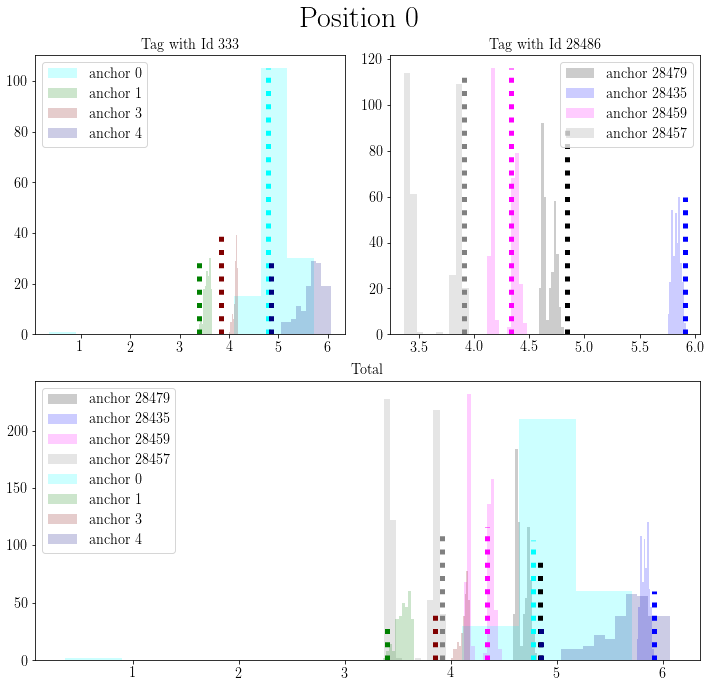

In [2]:
import plots_cti as plots
from experiments import read_experimental_data,N_POSITIONS

#tool = 'Pozyx'
tool = 'Ubiment'
april_tag_id = 333
pozyx_tag_id = 28486

if tool == 'Pozyx':
    path = 'data/Pozyx/Static/'
    name = 'pozyx_data_P{}.csv'
    runs = [0]
    tag_ids = [pozyx_tag_id]
    weighted = False
elif tool == 'Ubiment':
    path = 'data/Ubiment/Static/'
    name = 'data_P{}_{}.csv'
    runs = [1,2]
    tag_ids = [april_tag_id, pozyx_tag_id]
    weighted = True

results, anchors = read_experimental_data(path, name, runs, tag_ids, weighted)

## Compare weights (Ubiment only)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


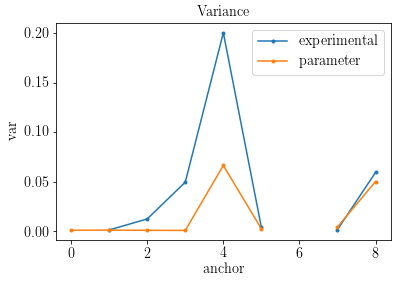

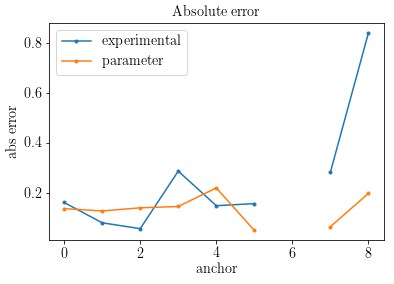

In [7]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from plots_cti import plot_matrix
index = -1
for result in results:
    var_exp = [np.var(d) for d in result.distances]
    var_exp[var_exp==0] = np.nan
    var = np.delete(result.var_avg[index,:],index)
    var[var==0] = np.nan
    plt.plot(var_exp, '.-', label='experimental')
    plt.plot(var, '.-', label='parameter')
    plt.title('Variance')
    plt.xlabel('anchor')
    plt.ylabel('var')
    plt.legend(loc='best')
    plt.show()
    
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    abs_error_exp = np.abs(np.sqrt(result.edm_avg[index,:]) - np.sqrt(porig.edm[index,:]))
    abs_error_exp[result.edm_avg[index,:]==0] = np.nan
    abs_error = np.delete(result.abs_error_avg[index,:],index)
    abs_error[abs_error==0] = np.nan
    
    plt.plot(abs_error_exp, '.-', label='experimental')
    plt.plot(abs_error, '.-', label='parameter')
    plt.title('Absolute error')
    plt.xlabel('anchor')
    plt.ylabel('abs error')
    plt.legend(loc='best')
    plt.show()

## Apply algorithms

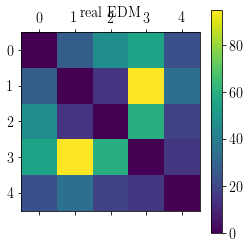

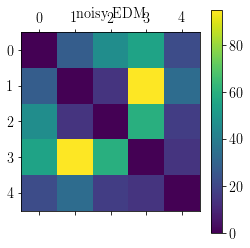

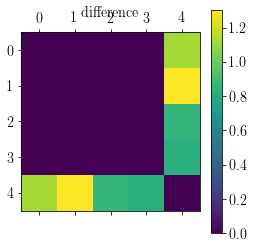

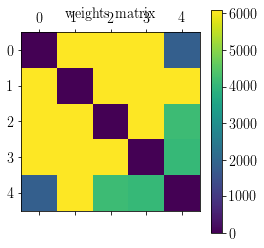

estimate using mds...
...done
estimate using weighted mds...
err after sweep 2: 1008.1471300733974
err after sweep 3: 0.014872028717945796
err after sweep 4: 2.0920764261027216
err after sweep 5: 0.678810610961591
err after sweep 6: 0.3378472205349681
err after sweep 7: 0.15605619020061567
err after sweep 8: 0.07857053584120877
err after sweep 9: 0.04138968365259643
err after sweep 10: 0.022662094475890626
err after sweep 11: 0.012748649667628342
err after sweep 12: 0.007318830816075206
err after sweep 13: 0.004265884683263721
err after sweep 14: 0.0025152047837764258
err after sweep 15: 0.0014960693952161819
err after sweep 16: 0.0008958990438259207
err after sweep 17: 0.0005392937800934305
err after sweep 18: 0.0003259417153458344
err after sweep 19: 0.00019761086332437117
err after sweep 20: 0.00012009816236968618
weighted mds: did not converge after 20 sweeps
...done
estimate using SRLS...
...done
estimate using weighted SRlS...
...done


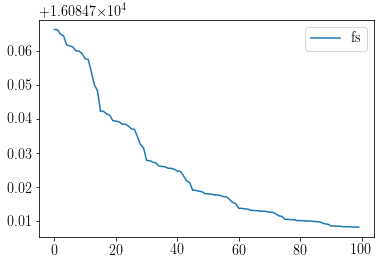

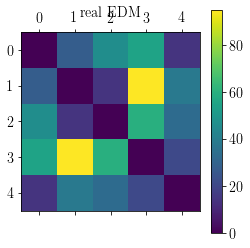

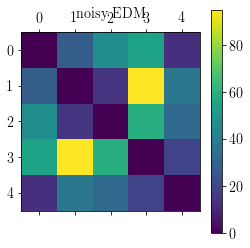

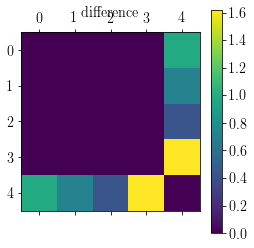

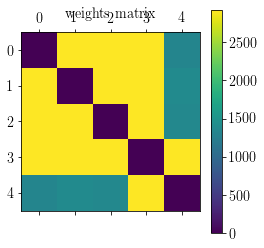

estimate using mds...
...done
estimate using weighted mds...
err after sweep 2: 627.0201951566391
err after sweep 3: 94.89004007364707
err after sweep 4: 5.308589932259025
err after sweep 5: 0.2708384971920168
err after sweep 6: 0.022783315461936127
err after sweep 7: 0.0026918873653016817
err after sweep 8: 0.00041336626077281835
weighted mds: converged after 9 sweeps.
...done
estimate using SRLS...
...done
estimate using weighted SRlS...
...done


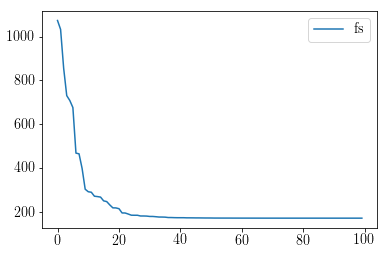

In [128]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from algorithms import reconstruct_mds, reconstruct_srls, reconstruct_weighted
from plots_cti import plot_matrix
    
points_mds = []
points_mds_weighted = []
points_srls = []
points_srls_weighted = []
points_original = []

#weight_method = 'bias'
weight_method = 'sigma'
#weight_method = 'LOESS'

printout=False

for result in results:
    N = result.edm_avg.shape[0]
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    index = N-1
    other = np.delete(np.arange(N),index)
    
    edm = result.edm_avg
    pnoisy = porig.copy()
    pnoisy.edm[index,other] = edm[index,other]
    pnoisy.edm[other,index] = edm[other,index]
    
    plot_matrix(porig.edm, 'real EDM')
    plot_matrix(pnoisy.edm,'noisy EDM')
    plot_matrix(porig.edm-pnoisy.edm,'difference')
    
    if weight_method == 'LOESS':
        max_dik = np.max(pnoisy.edm,axis=1)**(0.5)
        max_dkj = np.max(pnoisy.edm,axis=0)**(0.5)
        weights_matrix = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                hij = max(max_dik[i],max_dkj[j])
                weights_matrix[i,j] = np.exp(-pnoisy.edm[i,j]/hij**2)
    else:
        if weight_method == 'bias':
            if tool == 'Pozyx':
                # experimental bias 
                bias = np.sqrt(np.abs(porig.edm[index,other] - pnoisy.edm[index,other]))
            else:
                # parametric bias
                bias = result.abs_error_avg[index, other]
            
            weights = divide_where_nonzero(np.ones(bias.shape),bias)
        elif weight_method == 'sigma':
            if tool == 'Pozyx':
                # experimental sigma
                from basics import divide_where_nonzero
                sigma2 = np.array([np.var(d) for d in result.distances])
                sigma2[np.isnan(sigma2)] = 0
            
            else:
                # parametric sigma
                sigma2 = result.var_avg[index,other]
            weights = divide_where_nonzero(np.ones(sigma2.shape),sigma2)
        else:
            print('unknown weighting method')
        weights_matrix = np.ones((N,N))*max(weights)
        weights_matrix[index,other] = weights
        weights_matrix[other,index] = weights
    # set weights to zero where measurements are missing
    weights_matrix[pnoisy.edm == 0] = 0.0
    plot_matrix(weights_matrix, 'weights matrix')
    
    print('estimate using mds...')
    Xmds = reconstruct_mds(pnoisy.edm, porig.points, False, 'geometric')
    print('...done')
    print('estimate using weighted mds...')
    Xmds_weighted, fs, err_edms, err_points = reconstruct_weighted(pnoisy.edm, weights_matrix, porig.points, Xmds, porig.points, False)
    print('...done')
    print('estimate using SRLS...')
    Xsrls = reconstruct_srls(pnoisy.edm, porig.points, False, index=index)
    print('...done')
    print('estimate using weighted SRlS...')
    Xsrls_weighted = reconstruct_srls(pnoisy.edm, porig.points, False, weights=weights_matrix)
    print('...done')
    plt.plot(fs[-100:],label='fs')
    plt.legend(loc='best')
    plt.show()
    
    if (printout):
        pmds = create_from_points(Xmds, PointConfiguration)
        pmds_weighted = create_from_points(Xmds_weighted, PointConfiguration)
        psrls = create_from_points(Xsrls, PointConfiguration)
        psrls_weighted = create_from_points(Xsrls_weighted, PointConfiguration)
        print('Noisy edm error',np.linalg.norm(pnoisy.edm-porig.edm))
        print('SRLS edm error',np.linalg.norm(psrls.edm-porig.edm))
        print('MDS edm error ',np.linalg.norm(pmds.edm-porig.edm))
        plt.matshow(porig.edm-psrls.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff SRLS {}'.format(i))
        plt.show()
        plt.matshow(porig.edm-pmds.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff MDS {}'.format(i))
        plt.show()
    
    points_original.append(porig.points)
    points_mds.append(Xmds)
    points_mds_weighted.append(Xmds_weighted)
    points_srls.append(Xsrls)
    points_srls_weighted.append(Xsrls_weighted.copy())

## 2D Visualization

rmse mds 0.1761440226273985
rmse mds weighted 0.13561399785657696
rmse srls 0.20281433046424427
rmse srls weighted 0.19198432688666395


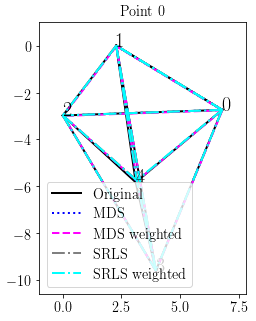

rmse mds 0.2317063137969956
rmse mds weighted 0.06771776913951522
rmse srls 0.22745680767079132
rmse srls weighted 0.23760028549584603


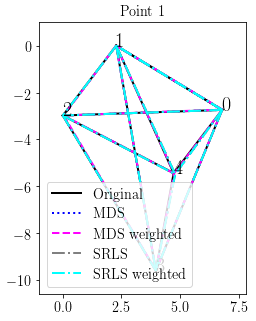

In [129]:
from plots_cti import plot_point_sets
from basics import rmse

n_methods = 4
names=['Original','MDS','MDS weighted','SRLS','SRLS weighted']
rmses = np.zeros((n_methods, N_POSITIONS))
size = [5,5]
for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls = points_srls[i]
    Xsrls_weighted = points_srls_weighted[i]
    rmse_mds = rmse(Xmds[-1,:], Xorig[-1,:])
    rmse_srls = rmse(Xsrls[-1,:], Xorig[-1,:])
    rmse_srls_weighted = rmse(Xsrls_weighted[-1,:], Xorig[-1,:])
    rmse_mds_weighted = rmse(Xmds_weighted[-1,:], Xorig[-1,:])
    
    rmses[:,i] = [rmse_mds, rmse_mds_weighted, rmse_srls, rmse_srls_weighted]
    print('rmse mds', rmse_mds)
    print('rmse mds weighted', rmse_mds_weighted)
    print('rmse srls', rmse_srls)
    print('rmse srls weighted', rmse_srls_weighted)
    
    plot_point_sets([Xorig,Xmds,Xmds_weighted,Xsrls,Xsrls_weighted],'Point {}'.format(i),size=size,names=names)
    #plot_points(Xsrls, title='SRLS, rmse={:2.2e}'.format(rmse_slrs), size=size)
    #plot_points(Xmds, title='MDS, rmse={:2.2e}'.format(rmse_mds),size=size)

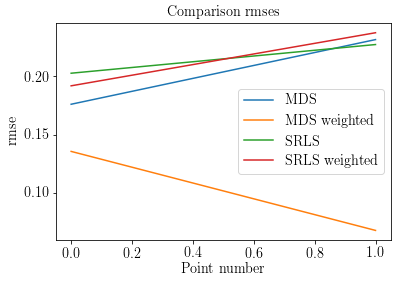

In [130]:
for i,method in enumerate(rmses):
    plt.plot(method,label=names[i+1])
plt.legend(loc='best')
plt.xlabel('Point number')
plt.ylabel('rmse')
plt.title('Comparison rmses')
plt.show()

## 3D Visualization

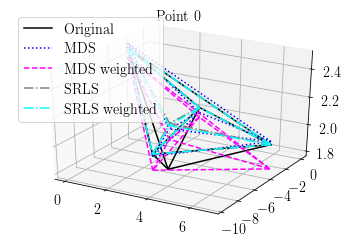

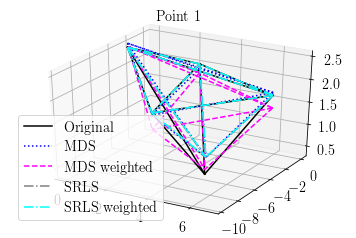

In [131]:
from plots_cti import plot_point_sets_3d

for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls_weighted = points_srls_weighted[i]
    plot_points = [Xorig, Xmds, Xmds_weighted, Xsrls, Xsrls_weighted]
    plot_point_sets_3d(plot_points, names, 'Point {}'.format(i))